In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks', palette='Set2')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def moran_process(N, r, mu_a, mu_A, num_a, num_A, sim_index):
    
    time_steps = 0

    while 0 < num_a < N:
        prob_birth = ((r * num_a)*(1 - mu_a) / (r * num_a + num_A) 
                      + (num_A * mu_A) / (r * num_a + num_A)) * num_A / N
        prob_death = ((num_A)*(1 - mu_A) / (r * num_a + num_A) 
                      + (r * num_a)*(mu_a) / (r * num_a + num_A)) * num_a / N
        prob_stat = 1 - prob_birth - prob_death
        event_index = np.random.choice(3, p = [prob_birth, prob_death, prob_stat])
        if event_index == 0:
            num_a += 1
            num_A -= 1
        elif event_index == 1:
            num_a -= 1
            num_A += 1
        time_steps += 1
        
    #print("Simulation {} is Done.".format(sim_index))
    

    return num_a == N, time_steps, num_a

In [3]:
num_a = 1
mu_a = 0.0
mu_A = 0.0
r = 1
num_sims = 20000
population_sizes = [2, 5, 7, 10]
expected_fix_probs = []
expected_fix_time = []


for pop in population_sizes:
    print("Population Size: ", pop)
    simulations = [moran_process(pop, r, mu_a, mu_A, num_a, pop - num_a, i) for i in range(num_sims)]
    fixations,times,_ = zip(*simulations)
    fixations = np.asarray(fixations)
    times = np.asarray(times)
    expected_fix_probs.append(np.mean(fixations))
    expected_fix_time.append(times[fixations])

Population Size:  2
Population Size:  5
Population Size:  7
Population Size:  10


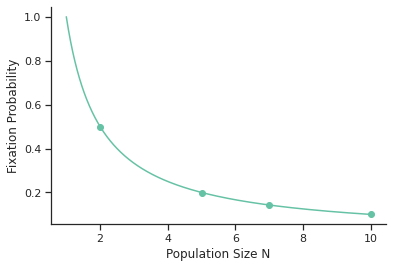

In [4]:
def fixation_probability_neutral(N):
    return 1 / N;

pop_sizes = np.linspace(1, 10, 1000)

plt.ylabel('Fixation Probability')
plt.xlabel('Population Size N')
plt.plot(pop_sizes, fixation_probability_neutral(pop_sizes))
plt.scatter(population_sizes, expected_fix_probs)
sns.despine()
plt.show()

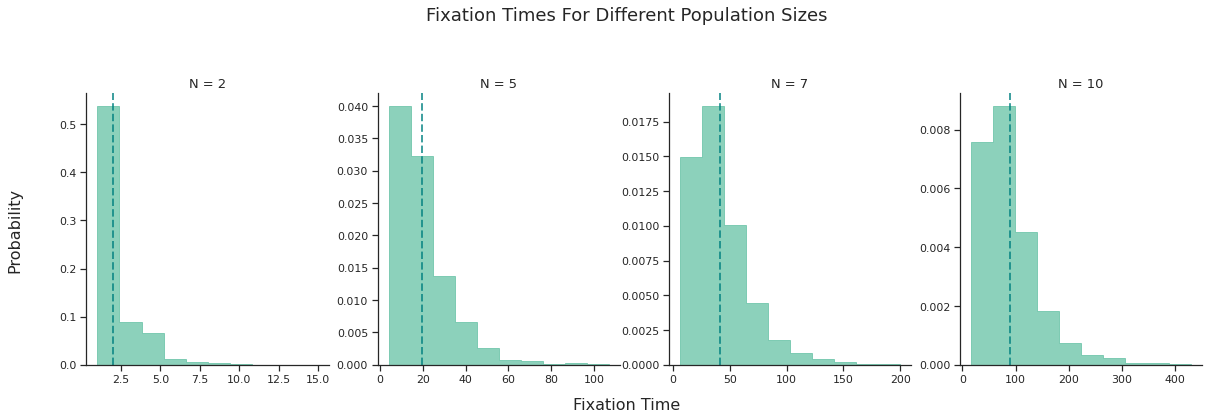

In [5]:
#Vertical line represents the mean
fig, ax = plt.subplots(1, 4, figsize=(20,5))
fig.suptitle('Fixation Times For Different Population Sizes', fontsize=18, y=1.12)
fig.text(0.5, 0.0, 'Fixation Time', ha='center', fontsize=16)
fig.text(0.07, 0.5, 'Probability', va='center', rotation='vertical', fontsize=16)

for i in range(len(population_sizes)):
  data = expected_fix_time[i]
  ax[i].hist(data, density=True, 
         alpha=0.75, histtype = 'step', fill=True)
  ax[i].axvline(np.mean(data), color='teal', linestyle='dashed', linewidth=2, alpha=0.75)
  sns.despine()
  ax[i].set_title('N = {0}'.format(population_sizes[i]), fontsize=13)
  fig.show()

In [6]:
def moran_process_stationary_dist(N, r, mu_a, mu_A, num_a, num_A, sim_index, max_time):

    for i in range(max_time):
        prob_birth = ((r * num_a)*(1 - mu_a) / (r * num_a + num_A) 
                      + (num_A * mu_A) / (r * num_a + num_A)) * num_A / N
        prob_death = ((num_A)*(1 - mu_A) / (r * num_a + num_A) 
                      + (r * num_a)*(mu_a) / (r * num_a + num_A)) * num_a / N
        prob_stat = 1 - prob_birth - prob_death
        event_index = np.random.choice(3, p = [prob_birth, prob_death, prob_stat])
        if event_index == 0:
            num_a += 1
            num_A -= 1
        elif event_index == 1:
            num_a -= 1
            num_A += 1
    

    return num_a

In [7]:
def generate_transition_matrix(N,mu_a,mu_A):
    T=np.zeros([N+1,N+1])
    for i in range(N+1):
        if i<N:
            T[i,i+1]=((i/N)*(1-mu_a)+((N-i)/N)*mu_A)*((N-i)/N)
        if i>0:
            T[i,i-1]=(((N-i)/N)*(1-mu_A)+(i/N)*mu_a)*(i/N)
        T[i,i]=1-((i/N)*(1-mu_a)+((N-i)/N)*mu_A)*((N-i)/N)-(((N-i)/N)*(1-mu_A)+(i/N)*mu_a)*(i/N)
    return T

def generate_transition_matrix_selection(N,mu_a,mu_A,r):  #constant fitness
    T=np.zeros([N+1,N+1])
    for i in range(N+1):
        frac1=(r*i)/(r*i+N-i)
        frac2=(N-i)/(r*i+N-i)
        if i<N:
            T[i,i+1]=(frac1*(1-mu_a)+(1-frac1)*mu_A)*((N-i)/N)
        if i>0:
            T[i,i-1]=(frac2*(1-mu_A)+(1-frac2)*mu_a)*(i/N)
        T[i,i]=1-(frac1*(1-mu_a)+(1-frac1)*mu_A)*((N-i)/N)-(frac2*(1-mu_A)+(1-frac2)*mu_a)*(i/N)
    return T

def generate_last_state(N,L,pi_0,mu_a,mu_A,typ,r):
    S=np.eye(N+1,N+1)
    if typ=='selection':
        T=generate_transition_matrix_selection(N,mu_a,mu_A,r)
    else:
        T=generate_transition_matrix(N,mu_a,mu_A) 
    for t in range(1,L):
        S=np.dot(T,S)
    return np.dot(pi_0,S)

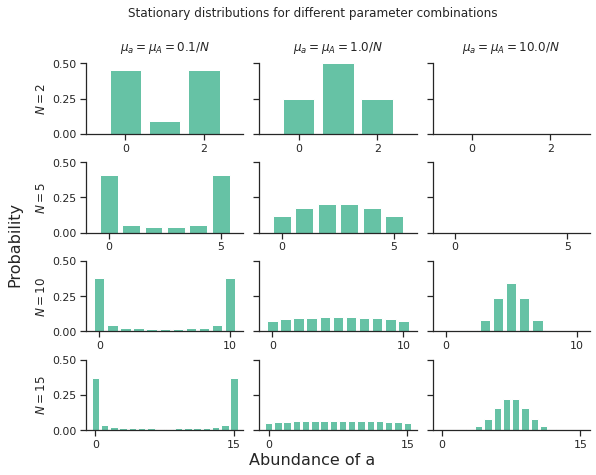

In [21]:
N=[2,5,10,15] 
L=1000
scale_parameter=[0.1,1,10.]
f, axes = plt.subplots(len(N),len(scale_parameter),figsize=(8,6))
f.text(0.5, -0.01, 'Abundance of a', ha='center', fontsize=16)
f.text(-0.03, 0.5, 'Probability', va='center', rotation='vertical', fontsize=16)
for i in range(len(N)):
    pi_0=np.divide(np.ones(N[i]+1),N[i]+1).reshape(1,N[i]+1)#np.eye(1,N[i]+1,1)   #Indicates the initial state probability.
    for j in range(len(scale_parameter)):
        mu_a=mu_A=scale_parameter[j]/N[i]
        if mu_a<=1:
            pi_last=generate_last_state(N[i],L-1,pi_0,mu_a,mu_A,'ordinary',r=None) 
            pi_last_st=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'ordinary',r=None) 
            if np.sum(np.abs(pi_last-pi_last_st))<0.000001:
                #print('Given N=%d and mu_a=mu_A=%1.1f/N the stationary distribution is' %(N[i],scale_parameter[j]), pi_last)
                axes[i,j].bar(range(N[i]+1),pi_last.reshape(N[i]+1))
        if i==0: 
            axes[i,j].set_title(r'$\mu_a=\mu_A=%1.1f/N$' %(scale_parameter[j]),y=1.1)    
        if j==0:
            axes[i,j].set_ylabel(r'$N=%d$' %(N[i]))
        else:
            axes[i,j].set_yticklabels([])  
        axes[i,j].set_ylim([0,0.5])
        axes[i,j].set_yticks(np.linspace(0,0.5,3))
        axes[i,j].set_xlim([-1,N[i]+1])
        axes[i,j].set_xticks([0,N[i]])   
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')
    #print('*************************************************************')
plt.suptitle('Stationary distributions for different parameter combinations',y=1.05)
plt.tight_layout(h_pad=0.5,w_pad=1)
fig.show()

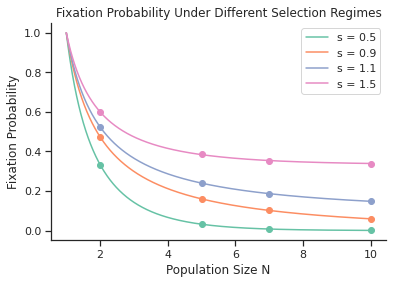

In [9]:
def fixation_probability_selection(r, N):
    return (1 - 1/r)/(1 - 1/(r**N))

num_a = 1
mu_a = 0.0
mu_A = 0.0
r = 1
num_sims = 20000
selection_regimes = [0.5, 0.9, 1.1, 1.5]
population_sizes = [2, 5, 7, 10]
pop_sizes = np.linspace(1, 10, 1000)

for selection in selection_regimes:
    expected_fix_probs = []
    expected_fix_time = []
    for pop in population_sizes:
        simulations = [moran_process(pop, selection, mu_a, mu_A, num_a, pop - num_a, i) for i in range(num_sims)]
        fixations,times,_ = zip(*simulations)
        fixations = np.asarray(fixations)
        times = np.asarray(times)
        expected_fix_probs.append(np.mean(fixations))
        expected_fix_time.append(np.mean(times[fixations]))
        
    sns.despine()
    plt.ylabel('Fixation Probability')
    plt.xlabel('Population Size N')
    plt.plot(pop_sizes, fixation_probability_selection(selection, pop_sizes), label='s = {}'.format(selection))
    plt.scatter(population_sizes, expected_fix_probs)

plt.title('Fixation Probability Under Different Selection Regimes')
plt.legend()

Population Size:  2
Population Size:  5
Population Size:  7
Population Size:  10


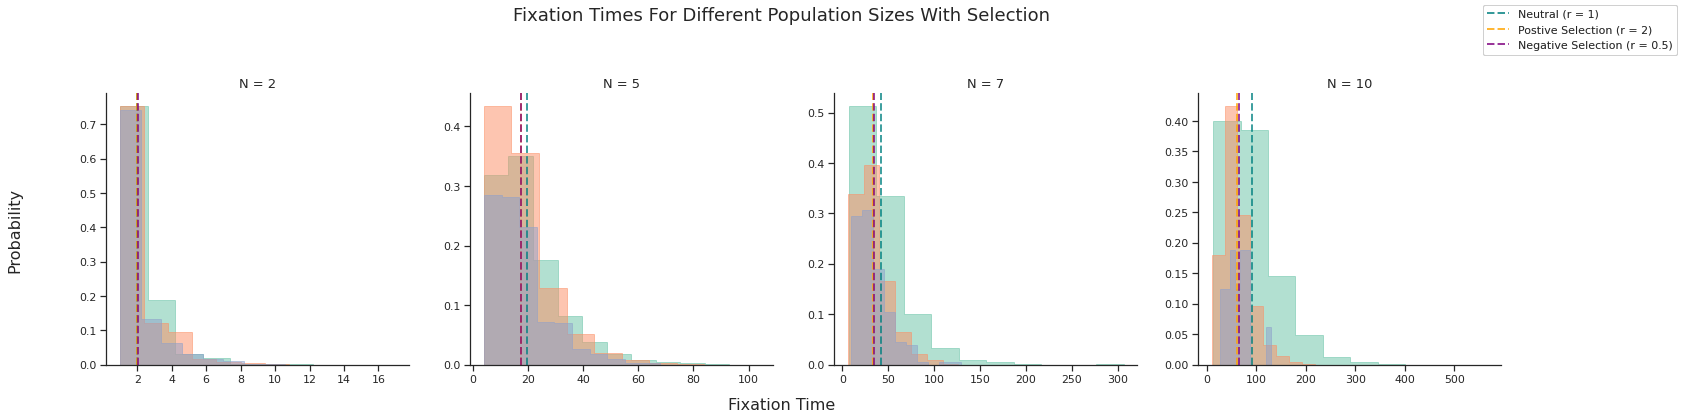

In [10]:
# Vertical Lines Denote The Mean Fixation Time

num_a = 1
mu_a = 0.0
mu_A = 0.0
neutral_r = 1
pos_r = 2
neg_r = 0.5
num_sims = 20000
population_sizes = [2, 5, 7, 10]
expected_fix_time = []


for pop in population_sizes:
    print("Population Size: ", pop)
    sim_neutral = [moran_process(pop, neutral_r, mu_a, mu_A, num_a, pop - num_a, i) for i in range(num_sims)]
    sim_pos_sel = [moran_process(pop, pos_r, mu_a, mu_A, num_a, pop - num_a, i) for i in range(num_sims)]
    sim_neg_sel = [moran_process(pop, neg_r, mu_a, mu_A, num_a, pop - num_a, i) for i in range(num_sims)]
    fix_neutral,times_neutral,_ = zip(*sim_neutral)
    fix_pos_sel,times_pos_sel,_ = zip(*sim_pos_sel)
    fix_neg_sel,times_neg_sel,_ = zip(*sim_neg_sel)
    fix_neutral = np.asarray(fix_neutral)
    fix_pos_sel = np.asarray(fix_pos_sel)
    fix_neg_sel = np.asarray(fix_neg_sel)
    times_neutral = np.asarray(times_neutral)
    times_pos_sel = np.asarray(times_pos_sel)
    times_neg_sel = np.asarray(times_neg_sel)
    expected_fix_time.append([times_neutral[fix_neutral], times_pos_sel[fix_pos_sel], times_neg_sel[fix_neg_sel]])

fig, ax = plt.subplots(1, 4, figsize=(25,5))
fig.suptitle('Fixation Times For Different Population Sizes With Selection', fontsize=18, y=1.12)
fig.text(0.5, 0.0, 'Fixation Time', ha='center', fontsize=16)
fig.text(0.07, 0.5, 'Probability', va='center', rotation='vertical', fontsize=16)

for i in range(len(population_sizes)):
  data = expected_fix_time[i][0]
  ax[i].hist(data, 
         alpha=0.5, histtype = 'step', fill=True, weights=np.ones_like(data) / len(data))
  ax[i].axvline(np.mean(data), color='teal', linestyle='dashed', linewidth=2, alpha=0.75)
  data = expected_fix_time[i][1]
  ax[i].hist(data, 
         alpha=0.5, histtype = 'step', fill=True, weights=np.ones_like(data) / len(data))
  ax[i].axvline(np.mean(data), color='orange', linestyle='dashed', linewidth=2, alpha=0.75)
  data = expected_fix_time[i][2]
  ax[i].hist(data, 
         alpha=0.5, histtype = 'step', fill=True, weights=np.ones_like(data) / len(data))
  ax[i].axvline(np.mean(data), color='purple', linestyle='dashed', linewidth=2, alpha=0.75)
  sns.despine()
  ax[i].set_title('N = {0}'.format(population_sizes[i]), fontsize=13)
  fig.legend(["Neutral (r = 1)", "Postive Selection (r = 2)", "Negative Selection (r = 0.5)"])
  fig.show()

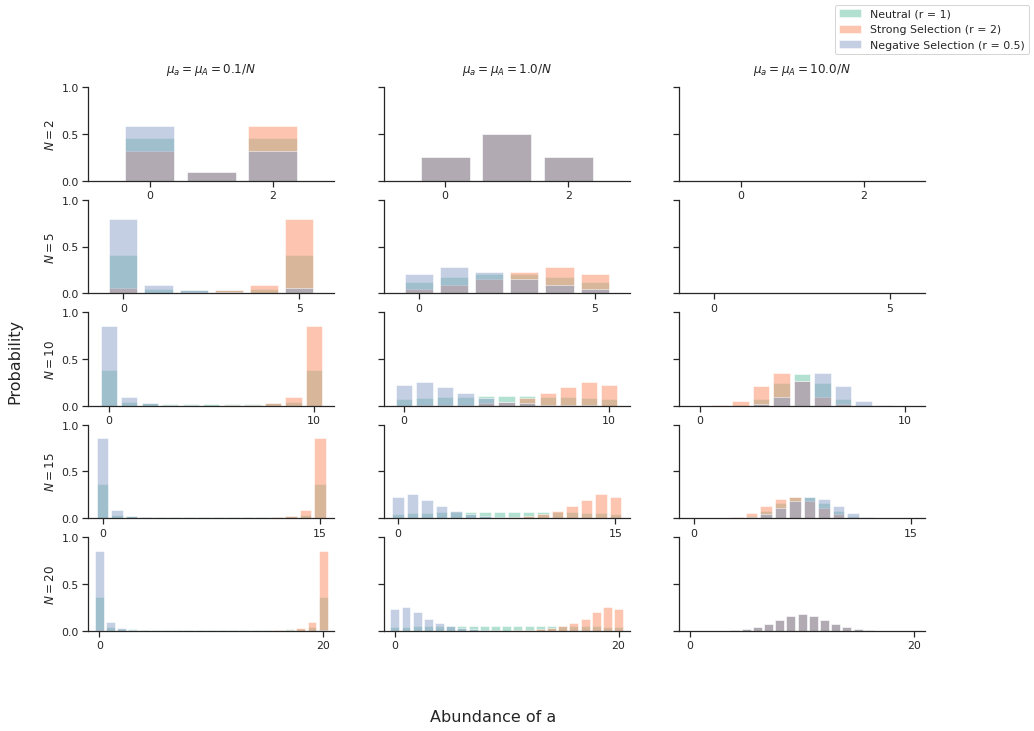

In [14]:
N=[2,5,10,15,20] #population sizes
r=[2,0.5] #selection coefficient
L=1000
scale_parameter=[0.1,1,10.]
f, axes = plt.subplots(len(N),len(scale_parameter),figsize=(15,10))
f.text(0.5, 0.0, 'Abundance of a', ha='center', fontsize=16)
f.text(0.05, 0.5, 'Probability', va='center', rotation='vertical', fontsize=16)
for i in range(len(N)):
    pi_0=np.divide(np.ones(N[i]+1),N[i]+1).reshape(1,N[i]+1)#np.eye(1,N[i]+1,1)   #Indicates the initial state probability.
    for j in range(len(scale_parameter)):
        mu_a=mu_A=scale_parameter[j]/N[i]
        if mu_a<=1:
            pi_last=generate_last_state(N[i],L-1,pi_0,mu_a,mu_A,'ordinary',r=None) 
            pi_last_st=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'ordinary',r=None) 
            if np.sum(np.abs(pi_last-pi_last_st))<0.0001:
                #print('Given N=%d and mu_a=mu_A=%1.1f/N the stationary distribution is' %(N[i],scale_parameter[j]), pi_last)
                axes[i,j].bar(range(N[i]+1),pi_last.reshape(N[i]+1),color='C0',alpha=0.5)
            pi_last=generate_last_state(N[i],L-1,pi_0,mu_a,mu_A,'selection',r[0]) 
            pi_last_st=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'selection',r[0]) 
            if np.sum(np.abs(pi_last-pi_last_st))<0.0001:
                #print('Given N=%d and mu_a=mu_A=%1.1f/N the stationary distribution is' %(N[i],scale_parameter[j]), pi_last)
                axes[i,j].bar(range(N[i]+1),pi_last.reshape(N[i]+1),color='C1',alpha=0.5)
            pi_last=generate_last_state(N[i],L-1,pi_0,mu_a,mu_A,'selection',r[1]) 
            pi_last_st=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'selection',r[1]) 
            if np.sum(np.abs(pi_last-pi_last_st))<0.0001:
                #print('Given N=%d and mu_a=mu_A=%1.1f/N the stationary distribution is' %(N[i],scale_parameter[j]), pi_last)
                axes[i,j].bar(range(N[i]+1),pi_last.reshape(N[i]+1),color='C2',alpha=0.5)
        if i==0: 
            axes[i,j].set_title(r'$\mu_a=\mu_A=%1.1f/N$' %(scale_parameter[j]),y=1.1)    
        if j==0:
            axes[i,j].set_ylabel(r'$N=%d$' %(N[i]))
        else:
            axes[i,j].set_yticklabels([])  
        axes[i,j].set_ylim([0,0.5])
        axes[i,j].set_yticks(np.linspace(0,1,3))
        axes[i,j].set_xlim([-1,N[i]+1])
        axes[i,j].set_xticks([0,N[i]])   
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')
f.legend(['Neutral (r = 1)','Strong Selection (r = 2)', 'Negative Selection (r = 0.5)'])
f.show()